<a href="https://colab.research.google.com/github/NinaNikolova/data_mining_project/blob/main/python_games5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving video_game_reviews.csv to video_game_reviews (1).csv


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import re
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_csv('/content/video_game_reviews.csv')
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [40]:
df.drop(columns=['Game Title', 'Developer','Publisher'], inplace=True)
df['User Review Text'].unique()

array(['Solid game, but too many bugs.',
       'Great game, but the graphics could be better.',
       'Solid game, but the graphics could be better.',
       'Great game, but too many bugs.',
       'Solid game, but the gameplay is amazing.',
       'Disappointing game, but the gameplay is amazing.',
       'Great game, but the gameplay is amazing.',
       'Amazing game, but the gameplay is amazing.',
       'Disappointing game, but the graphics could be better.',
       'Amazing game, but too many bugs.',
       'Amazing game, but the graphics could be better.',
       'Disappointing game, but too many bugs.'], dtype=object)

In [41]:
def extract_essential(text):
    text = text.lower()
    if 'bug' in text:
        return 'bugs'
    elif 'graphics could be better' in text:
        return 'bad_graphics'
    elif 'gameplay is amazing' in text:
        return 'amazing_gameplay'
    else:
        return 'other'
df['User Review Text'] = df['User Review Text'].apply(extract_essential)
df['User Review Text'].unique()

array(['bugs', 'bad_graphics', 'amazing_gameplay'], dtype=object)

In [42]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players,Age Group Targeted_All Ages,Age Group Targeted_Kids,Age Group Targeted_Teens,Platform_Nintendo Switch,Platform_PC,...,Graphics Quality_Ultra,Soundtrack Quality_Excellent,Soundtrack Quality_Good,Soundtrack Quality_Poor,Story Quality_Excellent,Story Quality_Good,Story Quality_Poor,User Review Text_bad_graphics,User Review Text_bugs,Game Mode_Online
0,36.4,41.41,2015,55.3,1,True,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,38.3,57.56,2015,34.6,3,False,False,False,False,True,...,False,False,False,True,False,False,True,False,True,False
2,26.8,44.93,2012,13.9,5,False,False,True,False,True,...,False,False,True,False,False,False,False,True,False,False
3,38.4,48.29,2015,41.9,4,True,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
4,30.1,55.49,2022,13.2,1,False,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False


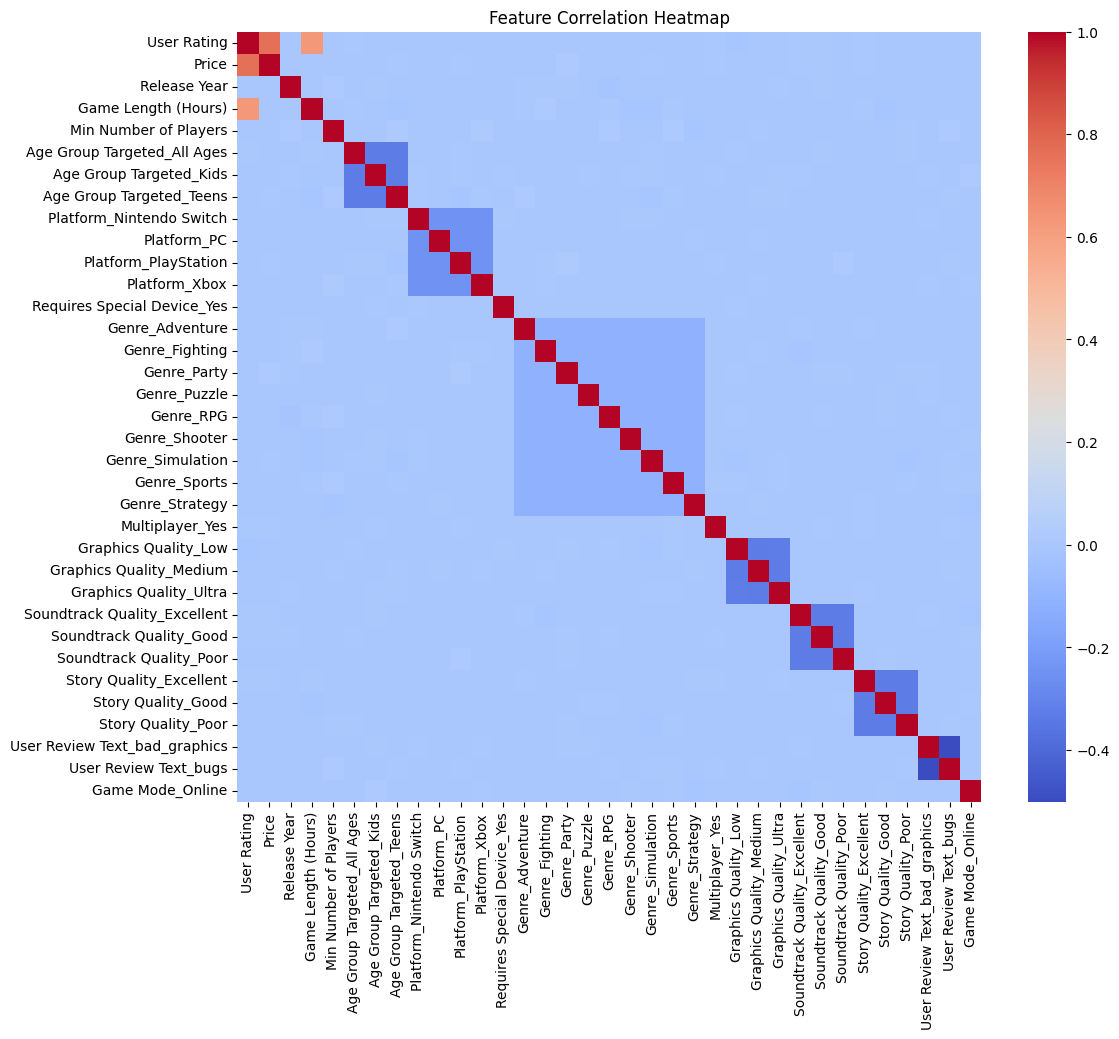

In [43]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [48]:
#Да се изберат най-важните характеристики (features) от данните, използвайки Random Forest регресионен модел и автоматичен feature selection.
y = df_encoded['User Rating']
X = df_encoded.drop(columns=['User Rating'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model - Създаваме Random Forest регресионен модел с 100 дървета и го обучаваме върху тренировъчните данни.
Този модел ще оцени кои входни признаци са най-полезни за предсказване на User Rating
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature selection - Използваме SelectFromModel, за да изберем автоматично само най-важните характеристики, определени от обучен модел.
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names - Взимаме имената на избраните колони (най-важните характеристики) и създаваме нов DataFrame df_selected_final, съдържащ само тях.
selected_columns = X.columns[selector.get_support()]
df_selected_final = df_encoded[selected_columns]

In [57]:
# Get selected feature names
selected_columns = X.columns[selector.get_support()]
importances = model.feature_importances_[selector.get_support()]
df_selected_final = df_encoded[selected_columns]
df_selected_final.head()

,Price,Game Length (Hours)
0,41.41,55.3
1,57.56,34.6
2,44.93,13.9
3,48.29,41.9
4,55.49,13.2


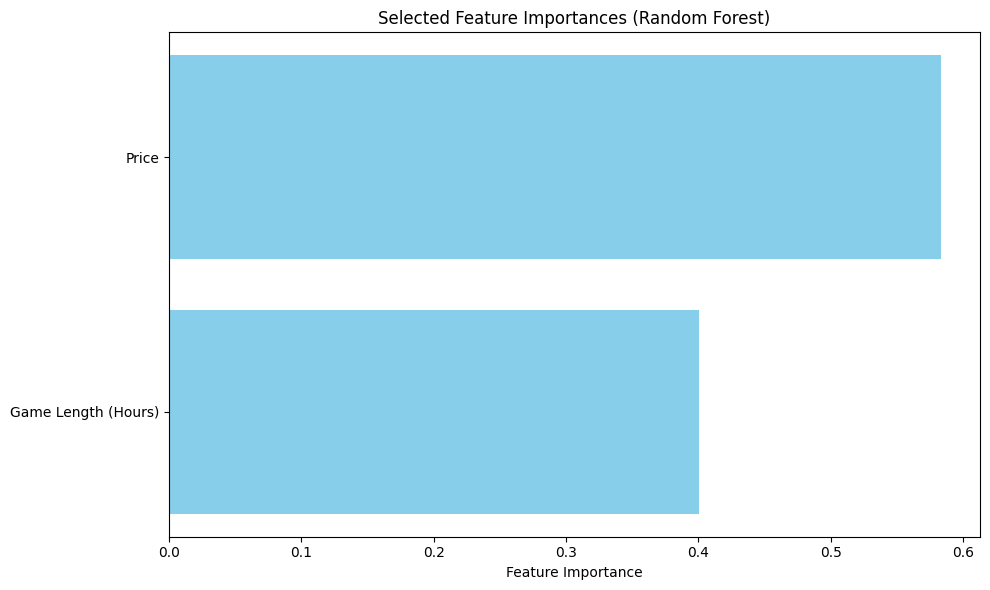

In [58]:
# Create DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': selected_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

In [60]:
# Предсказване върху тестовите данни
y_pred = model.predict(X_test)

# Изчисляване на метрики
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Средна квадратична грешка (MSE): {mse:.2f}")
print(f"Коефициент на детерминация (R²): {r2:.2f}")

Средна квадратична грешка (MSE): 1.46
Коефициент на детерминация (R²): 0.97
